**MONTHLY RENTAL CONDOMINIUM**
---
web scraping from https://www.livinginsider.com

# TASK 1 : import library
---

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# TASK 2 : scrape from website
---

In [ ]:
list_link = []
for i in range(1,2092):
    list_link.append('https://www.livinginsider.com/searchword/Condo/Rent/' + str(i) + '/%E0%B8%A3%E0%B8%A7%E0%B8%A1%E0%B8%9B%E0%B8%A3%E0%B8%B0%E0%B8%81%E0%B8%B2%E0%B8%A8-%E0%B9%80%E0%B8%8A%E0%B9%88%E0%B8%B2-%E0%B8%84%E0%B8%AD%E0%B8%99%E0%B9%82%E0%B8%94.html')

In [ ]:
# scrape title of each condominium
condo_title = []
def def_title(soupsoup):
    raw_data = soupsoup.find_all('div', {'class':'col-md-12 col-sm-12'})
    for t in raw_data:
        condo_title.append(t.text)
    return condo_title

In [ ]:
# scrape rental price of each condominium post
condo_price = []
def def_price(soupsoup):
    raw_data = soupsoup.find_all('div',{'class':'t-16'})
    for p in raw_data:
        condo_price.append(int(p.text.replace(',','').replace('฿','')))
    return condo_price

In [ ]:
# scrape reach of each condominium post
condo_reach = []
def def_reach(soupsoup):
    raw_data = soupsoup.find_all('div',attrs={'class':'istock-view pull-right'})
    for r in raw_data:
        condo_reach.append(r.text.split()[0])
    return condo_reach     

In [ ]:
# scrape create date of each condominium post
condo_cdate = []
def def_cdate(soupsoup):
    raw_data = soupsoup.find_all('div', {'class':'istock-lastdate pull-left'})
    for d in raw_data:
        condo_cdate.append(d.text.split())
    return condo_cdate

In [ ]:
# scrape location of each condominium post (location means group of this location)
condo_location = []
def def_location(soupsoup):
    raw_data = soupsoup.find_all('div', {'class':'col-md-12 col-sm-12 col-xs-12 ic-detail-zone'})
    for l in raw_data:
        condo_location.append(l.find('span').text)
    return condo_location

In [ ]:
# scrape detail date of each condominium post. This list have area of room, number of bedroom, number of bathroom and floor level 
condo_detail = []
def def_detail(soupsoup):
    raw_data = soupsoup.find_all('div', {'class':'col-md-12 col-sm-12 div-ic-detail'})
    for dt in raw_data:
        condo_detail.append(dt.text.split())
    return condo_detail

In [ ]:
# run to collect data 
for i in range(1,2092):
    r = requests.get(list_link[i-1])
    soup = BeautifulSoup(r.text, 'lxml')
    def_title(soup)
    def_price(soup)
    def_reach(soup)
    def_cdate(soup)
    def_location(soup)
    def_detail(soup)

# TASK 3 : clean data
---

In [ ]:
tt = []
for t in condo_title:
    tt.append(t.replace('\n', '').lstrip().rstrip())

for i in tt[:]:
    if i == '':
        tt.remove(i)
    elif i in ['แพ็กเกจพิเศษ ติดต่อสอบถามได้ที่Sale@Livinginsider.com', 'Foreigner Quota']:
        tt.remove(i)

condo_title = tt

In [ ]:
raw_data = pd.DataFrame([condo_title,condo_price,condo_reach,condo_location]).transpose()
raw_data_c = pd.DataFrame(condo_cdate)
raw_data_d = pd.DataFrame(condo_detail)

In [ ]:
raw_data = pd.merge(raw_data,raw_data_c,left_index=True, right_index=True)
raw_data = pd.merge(raw_data,raw_data_d,left_index=True, right_index=True)

In [ ]:
raw_data = raw_data.rename(columns={'0_x':'title', '1_x':'rent_price', '2_x':'reach', '3_x':'location_zone', 
                         '0_y':'cdate', '1_y':'ctime', 0:'area_mm', 1:'mm_measure', '2_y':'floor', 
                         '3_y':'floor_level', 4:'unit_room',5:'roomtype', 6:'unit_bath', 7:'bathroom' })

In [ ]:
raw_data = raw_data.drop_duplicates(keep='last', ignore_index=True)

 *change reach format (eg. 5k to 5000)*


In [ ]:
new_condo_reach = []
for r in raw_data['reach']:
    if r[-1] == 'k':
        y = float(r.replace('k',''))
        new_condo_reach.append(int(y * 1000))
    else:
        new_condo_reach.append(int(r))

In [ ]:
new_condo_reach = pd.DataFrame(new_condo_reach).reset_index()

In [ ]:
#merge to raw_data
raw_data = pd.merge(raw_data, new_condo_reach, on='index', how='inner')

In [ ]:
#drop reach column
raw_data = raw_data.drop(columns=['reach'])

 *merge cdate and ctime to datetime datatype before starting clean cdate and ctime unformat*

 find different day starting from crete post date, To current days just scrape data.

In [ ]:
for i in ['วินาทีที่แล้ว', 'นาทีที่แล้ว', 'ชั่วโมงที่แล้ว', 'เมื่อวานนี้']
    clean_oldtime_data = raw_data[raw_data['ctime'] != i ]

In [ ]:
raw_data = clean_oldtime_data.reset_index()

In [ ]:
raw_data['to_date'] = pd.to_datetime(raw_data['to_date'])
raw_data['from_date'] = raw_data['cdate'].map(str) + ' ' + raw_data['ctime'].map(str) 
raw_data['from_date'] = pd.to_datetime(raw_data['from_date'])
raw_data = raw_data.drop(columns=['cdate', 'ctime'])
raw_data['diff_day'] = (raw_data['to_date'] - raw_data['from_date']) / np.timedelta64(1, 'D')

 *merge unit_room, roomtype, unit_bath and bathroom to separate into bedroom_unit and bathroom_unit numberical format*

In [ ]:
raw_data['room_detail'] = raw_data['unit_room'].map(str) + raw_data['roomtype'].map(str) + raw_data['unit_bath'].map(str) + raw_data['bathroom'].map(str)
raw_data = raw_data.drop(columns=['unit_room', 'roomtype', 'unit_bath', 'bathroom'])

In [ ]:
bedroom_unit = []
for i in raw_data['room_detail']:
    if i[0] == '1':
        bedroom_unit.append(1)
    elif i[0] == '2':
        bedroom_unit.append(2)
    elif i[0] == '3':
        bedroom_unit.append(3)
    elif i[0] == '4':
        bedroom_unit.append(4)
    elif i[0] == '5':
        bedroom_unit.append(5)
    elif i[0] == '8':
        bedroom_unit.append(8)
    else:
        bedroom_unit.append(0)
bedroom_unit = pd.DataFrame(bedroom_unit)

In [ ]:
bathroom_unit = []
for i in raw_data['room_detail']:
    if i[8] in ('1', '2', '3', '4', '5'):
        bathroom_unit.append(i[8])
    elif i[11] in ('1', '2', '3'):
        bathroom_unit.append(i[11])
    else:
        bathroom_unit.append(i[9])
bathroom_unit = pd.DataFrame(bathroom_unit)

In [ ]:
raw_data = pd.merge(raw_data, bedroom_unit, on='index', how='inner' )
raw_data = pd.merge(raw_data, bathroom_unit, on='index', how='inner' )

 *change datatype to correct format*

In [ ]:
raw_data['rent_price'] = raw_data['rent_price'].astype('int')
raw_data['area_mm'] = raw_data.to_numeric(df['area_mm'])
raw_data['new_reach'] = raw_data['new_reach'].astype('int')
raw_data['bedroom_unit'] = raw_data['bedroom_unit'].astype('int')
raw_data['bathroom_unit'] = raw_data['bathroom_unit'].astype('int')

 *export csv file to visualize in tableau*

In [ ]:
raw_data.to_csv('/lvinsider_data.csv')

# TASK 4 : Visualize 
---

# TASK 5: Analyzed correlation two independent variable
---

In [4]:
df_temp = pd.read_csv('/Users/natthakitngamcharoensin/Documents/projects/pythonxlivinginsider/lvinsider_data.csv')

In [5]:
df_temp.head()

,title,rent_price,location_zone,area_mm,floor_level,bedroom_unit,bathroom_unit,new_reach,to_date,from_date,diff_day
0,ให้เช่า คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,7000,สมุทรปราการ สำโรง,24.0,13,1,1,1200,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
1,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,24.0,11,1,1,1100,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
2,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.5,26,1,1,938,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
3,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.0,16,1,1,691,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
4,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.5,22,1,1,928,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694


 *drop unformat floor_level to dataFrame df_drop_area*

In [6]:
df_drop_area = df_temp

In [8]:
bins = ['11-20', '1-4', '21-50', '51-99']
for i in bins:
    df_drop_area = df_drop_area[df_drop_area['floor_level'] != i]

df_drop_area

,title,rent_price,location_zone,area_mm,floor_level,bedroom_unit,bathroom_unit,new_reach,to_date,from_date,diff_day
0,ให้เช่า คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,7000,สมุทรปราการ สำโรง,24.00,13,1,1,1200,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
1,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,24.00,11,1,1,1100,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
2,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.50,26,1,1,938,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
3,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.00,16,1,1,691,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
4,[ให้เช่า] คอนโด เคนซิงตัน สุขุมวิท-เทพารักษ์,6500,สมุทรปราการ สำโรง,21.50,22,1,1,928,2022-05-06 18:00:00,2022-05-04 23:59:00,1.750694
...,...,...,...,...,...,...,...,...,...,...,...
91005,1 ห้องนอน 35 ตร.ม. ราคาดีที่สุด,12000,บางนา แบริ่ง ลาซาล,35.01,14,1,1,35200,2022-05-06 18:00:00,2022-04-01 23:04:00,34.788889
91006,ใช้ชีวิต เหนือระดับ 2 ห้องนอน 185 ราชดำริ,120000,วิทยุ ชิดลม หลังสวน,119.00,27,2,2,36200,2022-05-06 18:00:00,2022-03-27 23:27:00,39.772917
91007,"ให้เช่า 2 นอน 100 ตร.ม. ไฮฟ์ ตากสิน 35,000",35000,วงเวียนใหญ่ เจริญนคร,100.01,27,2,2,37100,2022-05-06 18:00:00,2022-03-27 23:28:00,39.772222
91008,พิเศษ ห้องใหม่ ให้เช่า 2 นอน 50 ตร.ม. โว้คเพลส...,20000,บางนา แบริ่ง ลาซาล,50.01,7,2,1,39100,2022-05-06 18:00:00,2022-03-27 23:28:00,39.772222


In [76]:
df_corr = df_drop_area[['rent_price', 'area_mm', 'floor_level', 'bedroom_unit', 'bathroom_unit', 'new_reach','diff_day']]
df_corr['reach_per_day'] = df_corr['new_reach'] / df_corr['diff_day']
df_corr = df_corr.drop(columns=['new_reach', 'diff_day'])


/var/folders/j1/hmt_7d8j0p78qwrzkps1h50m0000gn/T/ipykernel_3078/2101163139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['reach_per_day'] = df_corr['new_reach'] / df_corr['diff_day']


In [77]:
df_corr.head()

,rent_price,area_mm,floor_level,bedroom_unit,bathroom_unit,reach_per_day
0,7000,24.0,13,1,1,685.442285
1,6500,24.0,11,1,1,628.322094
2,6500,21.5,26,1,1,535.787386
3,6500,21.0,16,1,1,394.700516
4,6500,21.5,22,1,1,530.075367


<Figure size 1080x720 with 0 Axes>

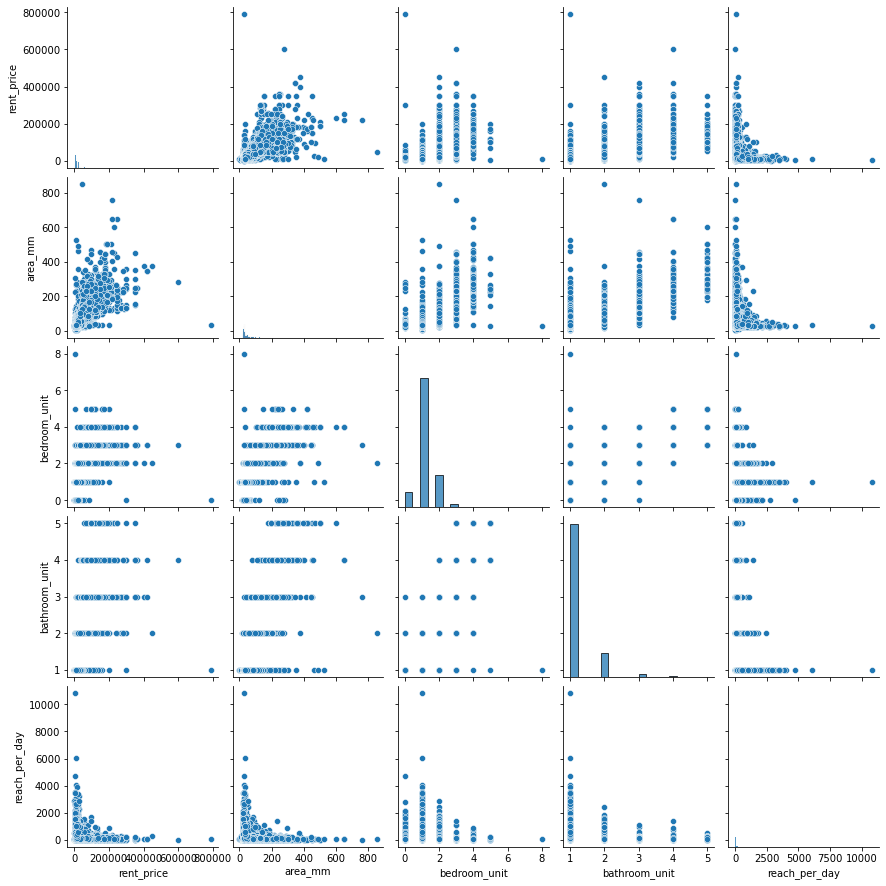

In [79]:
plt.figure(figsize=(15,10))
sns.pairplot(df_corr)

<AxesSubplot:>

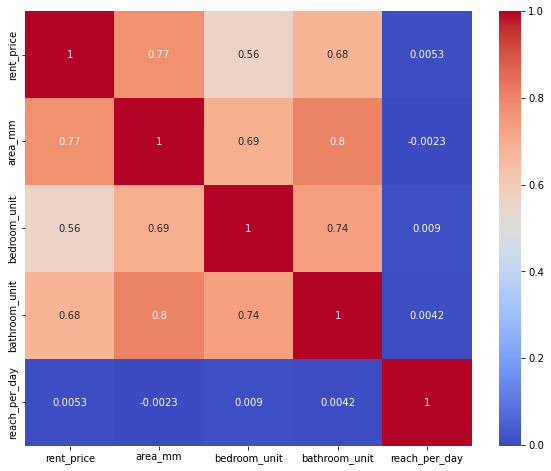

In [81]:
plt.figure(figsize=(10,8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')

 *Focus to rent_price and area_mm , These two variable probably have relation to check it use correlation*
 --

<AxesSubplot:xlabel='rent_price', ylabel='area_mm'>

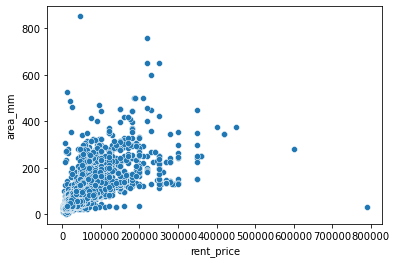

In [84]:
plt.figure()
sns.scatterplot(data=df_corr, x='rent_price', y='area_mm')

 **Test about rental price and area on each post**
 * H0 : There is no relationship between two variables
 * H1 : There is a relationship between two variables
 
 Use a correlation testing. A correlarion give two things, correlation coefficient, and a p-value.


In [85]:
from scipy.stats import stats

In [86]:
pearson_coef, p_value = stats.pearsonr(df_corr["area_mm"], df_corr["rent_price"])
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", round(p_value,3) )

Pearson Correlation Coefficient:  0.7725394306420976 and a P-value of: 0.0


 * As we can see the p-value is more than 0.05 hence, we accept the null hypothesis at a 95% level of confidence. **That means that there is a relationship between rental price and area on each post.**
 ---

 *Focus to reach_per_day and area_mm , These two variable probably have relation to check it use correlation*
 --

<AxesSubplot:xlabel='reach_per_day', ylabel='area_mm'>

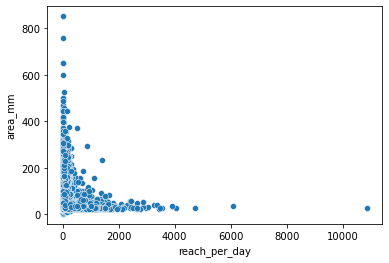

In [88]:
plt.figure()
sns.scatterplot(data=df_corr, x='reach_per_day', y='area_mm')

 **Test about rental price and reach/day on each post**
 * H0 : There is no relationship between two variables
 * H1 : There is a relationship between two variables
 
 Use a correlation testing. A correlarion give two things, correlation coefficient, and a p-value.

In [89]:
pearson_coef, p_value = stats.pearsonr(df_corr["area_mm"], df_corr["reach_per_day"])
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", round(p_value,3) )

Pearson Correlation Coefficient:  -0.0022538857866295503 and a P-value of: 0.557


 * As we can see the p-value is more than 0.05 hence, we accept the null hypothesis at a 95% level of confidence. **That means that there is no relationship between reach/day and area on each post.**
 ---

# TASK 6 : Find multiple linear regression
---

### Creating df_new dataframe prepare to find multiple regrassion
 *Selecting columns to dataframe df_new*

In [51]:
from scipy.stats import stats

In [10]:
df_drop_area.columns

Index(['title', 'rent_price', 'location_zone', 'area_mm', 'floor_level',
       'bedroom_unit', 'bathroom_unit', 'new_reach', 'to_date', 'from_date',
       'diff_day'],
      dtype='object')

In [11]:
df_new = df_drop_area[['rent_price', 'location_zone', 'area_mm', 'floor_level','bedroom_unit', 'bathroom_unit']]

df_new.head()

,rent_price,location_zone,area_mm,floor_level,bedroom_unit,bathroom_unit
0,7000,สมุทรปราการ สำโรง,24.0,13,1,1
1,6500,สมุทรปราการ สำโรง,24.0,11,1,1
2,6500,สมุทรปราการ สำโรง,21.5,26,1,1
3,6500,สมุทรปราการ สำโรง,21.0,16,1,1
4,6500,สมุทรปราการ สำโรง,21.5,22,1,1


### Use Encoder to create dataframe with binary

In [13]:
df_new['location_zone'] = df_new['location_zone'].astype('category')

/var/folders/j1/hmt_7d8j0p78qwrzkps1h50m0000gn/T/ipykernel_3078/1920348481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['location_zone'] = df_new['location_zone'].astype('category')


In [16]:
# Assigning numerical values and storing in another column
df_new['location_code'] = df_new['location_zone'].cat.codes
df_new

/var/folders/j1/hmt_7d8j0p78qwrzkps1h50m0000gn/T/ipykernel_3078/994499592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['location_code'] = df_new['location_zone'].cat.codes


,rent_price,location_zone,area_mm,floor_level,bedroom_unit,bathroom_unit,location_code
0,7000,สมุทรปราการ สำโรง,24.00,13,1,1,29
1,6500,สมุทรปราการ สำโรง,24.00,11,1,1,29
2,6500,สมุทรปราการ สำโรง,21.50,26,1,1,29
3,6500,สมุทรปราการ สำโรง,21.00,16,1,1,29
4,6500,สมุทรปราการ สำโรง,21.50,22,1,1,29
...,...,...,...,...,...,...,...
91005,12000,บางนา แบริ่ง ลาซาล,35.01,14,1,1,7
91006,120000,วิทยุ ชิดลม หลังสวน,119.00,27,2,2,27
91007,35000,วงเวียนใหญ่ เจริญนคร,100.01,27,2,2,26
91008,20000,บางนา แบริ่ง ลาซาล,50.01,7,2,1,7


In [17]:
df_new['location_zone'].astype('object').unique()

array(['สมุทรปราการ สำโรง', 'สุขุมวิท อโศก ทองหล่อ', 'สาทร นราธิวาส',
       'รัชดา ห้วยขวาง', 'เสรีไทย-นิด้า', 'บางซื่อ วงศ์สว่าง เตาปูน',
       'นานา', 'บางแค เพชรเกษม', 'วิภาวดี ดอนเมือง หลักสี่ ',
       'ท่าพระ ตลาดพลู วุฒากาศ', 'อ่อนนุช อุดมสุข',
       'พระราม 2 บางขุนเทียน', 'พระราม 5 ราชพฤกษ์ บางกรวย',
       'เกษตร นวมินทร์ ลาดปลาเค้า', 'นนทบุรี บางใหญ่ บางบัวทอง',
       'พระราม 9 เพชรบุรีตัดใหม่ RCA', 'ลาดพร้าว เซ็นทรัลลาดพร้าว',
       'เลียบทางด่วนรามอินทรา', 'ปิ่นเกล้า จรัญสนิทวงศ์',
       'วงเวียนใหญ่ เจริญนคร', 'บางนา แบริ่ง ลาซาล', 'นวมินทร์ รามอินทรา',
       'พัฒนาการ ศรีนครินทร์', 'ราชเทวี พญาไท ', 'เกษตรศาสตร์ รัชโยธิน',
       'พระราม 3 สาธุประดิษฐ์', 'สยาม จุฬา สามย่าน', 'แจ้งวัฒนะ เมืองทอง',
       'คลองเตย กล้วยน้ำไท', 'รามคำแหง หัวหมาก', 'ลาดกระบัง สุวรรณภูมิ',
       'วิทยุ ชิดลม หลังสวน', 'สะพานควาย จตุจักร',
       'รัตนาธิเบศร์ สนามบินน้ำ พระนั่งเกล้า',
       'ปทุมธานี รังสิต ธรรมศาสตร์', 'พระราม 8 สามเสน ราชวัตร',
       'สีลม ศาลาแดง บางรัก', 'โชคชัย

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
# creating initial dataframe
df_location = (
    'สมุทรปราการ สำโรง', 'สุขุมวิท อโศก ทองหล่อ', 'สาทร นราธิวาส',
       'รัชดา ห้วยขวาง', 'เสรีไทย-นิด้า', 'บางซื่อ วงศ์สว่าง เตาปูน',
       'นานา', 'บางแค เพชรเกษม', 'วิภาวดี ดอนเมือง หลักสี่ ',
       'ท่าพระ ตลาดพลู วุฒากาศ', 'อ่อนนุช อุดมสุข',
       'พระราม 2 บางขุนเทียน', 'พระราม 5 ราชพฤกษ์ บางกรวย',
       'เกษตร นวมินทร์ ลาดปลาเค้า', 'นนทบุรี บางใหญ่ บางบัวทอง',
       'พระราม 9 เพชรบุรีตัดใหม่ RCA', 'ลาดพร้าว เซ็นทรัลลาดพร้าว',
       'เลียบทางด่วนรามอินทรา', 'ปิ่นเกล้า จรัญสนิทวงศ์',
       'วงเวียนใหญ่ เจริญนคร', 'บางนา แบริ่ง ลาซาล', 'นวมินทร์ รามอินทรา',
       'พัฒนาการ ศรีนครินทร์', 'ราชเทวี พญาไท ', 'เกษตรศาสตร์ รัชโยธิน',
       'พระราม 3 สาธุประดิษฐ์', 'สยาม จุฬา สามย่าน', 'แจ้งวัฒนะ เมืองทอง',
       'คลองเตย กล้วยน้ำไท', 'รามคำแหง หัวหมาก', 'ลาดกระบัง สุวรรณภูมิ',
       'วิทยุ ชิดลม หลังสวน', 'สะพานควาย จตุจักร',
       'รัตนาธิเบศร์ สนามบินน้ำ พระนั่งเกล้า',
       'ปทุมธานี รังสิต ธรรมศาสตร์', 'พระราม 8 สามเสน ราชวัตร',
       'สีลม ศาลาแดง บางรัก', 'โชคชัย4 ลาดพร้าว71', 'อารีย์ อนุสาวรีย์ ',
       'มีนบุรี-ร่มเกล้า', 'ลาดพร้าว101 แฮปปี้แลนด์',
       'นครปฐม พุทธมณฑล ศาลายา', 'ราษฎร์บูรณะ สุขสวัสดิ์',
       'เยาวราช บางลำพู'
)
df_location = pd.DataFrame(df_location, columns=['location_zone'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df_location['location_code'] = labelencoder.fit_transform(df_location['location_zone'])
df_location

,location_zone,location_code
0,สมุทรปราการ สำโรง,29
1,สุขุมวิท อโศก ทองหล่อ,34
2,สาทร นราธิวาส,32
3,รัชดา ห้วยขวาง,18
4,เสรีไทย-นิด้า,41
5,บางซื่อ วงศ์สว่าง เตาปูน,6
6,นานา,5
7,บางแค เพชรเกษม,8
8,วิภาวดี ดอนเมือง หลักสี่,28
9,ท่าพระ ตลาดพลู วุฒากาศ,1


In [20]:
from sklearn.preprocessing import OneHotEncoder

In [21]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing location_zone column (label encoded values of location_code)
enc_df = pd.DataFrame(enc.fit_transform(df_location[['location_code']]).toarray())
# merge with main df df_location on key values
df_location = df_location.join(enc_df)
df_location

,location_zone,location_code,0,1,2,3,4,5,6,7,...,34,35,36,37,38,39,40,41,42,43
0,สมุทรปราการ สำโรง,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,สุขุมวิท อโศก ทองหล่อ,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,สาทร นราธิวาส,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,รัชดา ห้วยขวาง,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,เสรีไทย-นิด้า,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,บางซื่อ วงศ์สว่าง เตาปูน,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,นานา,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,บางแค เพชรเกษม,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,วิภาวดี ดอนเมือง หลักสี่,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ท่าพระ ตลาดพลู วุฒากาศ,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# creating initial dataframe
df_location_zone = (
        'สมุทรปราการ สำโรง', 'สุขุมวิท อโศก ทองหล่อ', 'สาทร นราธิวาส',
       'รัชดา ห้วยขวาง', 'เสรีไทย-นิด้า', 'บางซื่อ วงศ์สว่าง เตาปูน',
       'นานา', 'บางแค เพชรเกษม', 'วิภาวดี ดอนเมือง หลักสี่ ',
       'ท่าพระ ตลาดพลู วุฒากาศ', 'อ่อนนุช อุดมสุข',
       'พระราม 2 บางขุนเทียน', 'พระราม 5 ราชพฤกษ์ บางกรวย',
       'เกษตร นวมินทร์ ลาดปลาเค้า', 'นนทบุรี บางใหญ่ บางบัวทอง',
       'พระราม 9 เพชรบุรีตัดใหม่ RCA', 'ลาดพร้าว เซ็นทรัลลาดพร้าว',
       'เลียบทางด่วนรามอินทรา', 'ปิ่นเกล้า จรัญสนิทวงศ์',
       'วงเวียนใหญ่ เจริญนคร', 'บางนา แบริ่ง ลาซาล', 'นวมินทร์ รามอินทรา',
       'พัฒนาการ ศรีนครินทร์', 'ราชเทวี พญาไท ', 'เกษตรศาสตร์ รัชโยธิน',
       'พระราม 3 สาธุประดิษฐ์', 'สยาม จุฬา สามย่าน', 'แจ้งวัฒนะ เมืองทอง',
       'คลองเตย กล้วยน้ำไท', 'รามคำแหง หัวหมาก', 'ลาดกระบัง สุวรรณภูมิ',
       'วิทยุ ชิดลม หลังสวน', 'สะพานควาย จตุจักร',
       'รัตนาธิเบศร์ สนามบินน้ำ พระนั่งเกล้า',
       'ปทุมธานี รังสิต ธรรมศาสตร์', 'พระราม 8 สามเสน ราชวัตร',
       'สีลม ศาลาแดง บางรัก', 'โชคชัย4 ลาดพร้าว71', 'อารีย์ อนุสาวรีย์ ',
       'มีนบุรี-ร่มเกล้า', 'ลาดพร้าว101 แฮปปี้แลนด์',
       'นครปฐม พุทธมณฑล ศาลายา', 'ราษฎร์บูรณะ สุขสวัสดิ์',
       'เยาวราช บางลำพู'
)
df_location = pd.DataFrame(df_location_zone, columns=['location_zone'])
# generate binary values using get_dummies
dum_df = pd.get_dummies(df_location, columns=["location_zone"], prefix=[''] )
# merge with main df df_locaton on key values
df_location = df_location.join(dum_df)


'\n# creating instance of one-hot-encoder\nenc = OneHotEncoder(handle_unknown=\'ignore\')\n# passing bridge-types-cat column (label encoded values of bridge_types)\nenc_df = pd.DataFrame(enc.fit_transform(bridge_df[[\'Bridge_Types_Cat\']]).toarray())\n# merge with main df bridge_df on key values\nbridge_df = bridge_df.join(enc_df)\nbridge_df\n\n\n# creating initial dataframe\nbridge_types = (\'Arch\',\'Beam\',\'Truss\',\'Cantilever\',\'Tied Arch\',\'Suspension\',\'Cable\')\nbridge_df = pd.DataFrame(bridge_types, columns=[\'Bridge_Types\'])\n# generate binary values using get_dummies\ndum_df = pd.get_dummies(bridge_df, columns=["Bridge_Types"], prefix=["Type_is"] )\n# merge with main df bridge_df on key values\nbridge_df = bridge_df.join(dum_df)\nbridge_df\n'

In [24]:
df_location

,location_zone,_คลองเตย กล้วยน้ำไท,_ท่าพระ ตลาดพลู วุฒากาศ,_นครปฐม พุทธมณฑล ศาลายา,_นนทบุรี บางใหญ่ บางบัวทอง,_นวมินทร์ รามอินทรา,_นานา,_บางซื่อ วงศ์สว่าง เตาปูน,_บางนา แบริ่ง ลาซาล,_บางแค เพชรเกษม,...,_สุขุมวิท อโศก ทองหล่อ,_อารีย์ อนุสาวรีย์,_อ่อนนุช อุดมสุข,_เกษตร นวมินทร์ ลาดปลาเค้า,_เกษตรศาสตร์ รัชโยธิน,_เยาวราช บางลำพู,_เลียบทางด่วนรามอินทรา,_เสรีไทย-นิด้า,_แจ้งวัฒนะ เมืองทอง,_โชคชัย4 ลาดพร้าว71
0,สมุทรปราการ สำโรง,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,สุขุมวิท อโศก ทองหล่อ,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,สาทร นราธิวาส,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,รัชดา ห้วยขวาง,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,เสรีไทย-นิด้า,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,บางซื่อ วงศ์สว่าง เตาปูน,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,นานา,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,บางแค เพชรเกษม,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,วิภาวดี ดอนเมือง หลักสี่,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ท่าพระ ตลาดพลู วุฒากาศ,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 *Joing df_new and df_location to dataframe df_real*

In [25]:
df_real = pd.merge(df_new, df_location, on='location_zone', how='inner')

In [26]:
df_real = df_real.drop(columns='location_code')

In [27]:
df_real.columns = df_real.columns.str.replace('_','')

In [28]:
df_real.head()

,rentprice,locationzone,areamm,floorlevel,bedroomunit,bathroomunit,คลองเตย กล้วยน้ำไท,ท่าพระ ตลาดพลู วุฒากาศ,นครปฐม พุทธมณฑล ศาลายา,นนทบุรี บางใหญ่ บางบัวทอง,...,สุขุมวิท อโศก ทองหล่อ,อารีย์ อนุสาวรีย์,อ่อนนุช อุดมสุข,เกษตร นวมินทร์ ลาดปลาเค้า,เกษตรศาสตร์ รัชโยธิน,เยาวราช บางลำพู,เลียบทางด่วนรามอินทรา,เสรีไทย-นิด้า,แจ้งวัฒนะ เมืองทอง,โชคชัย4 ลาดพร้าว71
0,7000,สมุทรปราการ สำโรง,24.0,13,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6500,สมุทรปราการ สำโรง,24.0,11,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6500,สมุทรปราการ สำโรง,21.5,26,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6500,สมุทรปราการ สำโรง,21.0,16,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6500,สมุทรปราการ สำโรง,21.5,22,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Find multiple linear regression

In [30]:
x = df_real[[
    'areamm', 'floorlevel', 'bedroomunit',
       'bathroomunit', 'คลองเตย กล้วยน้ำไท', 'ท่าพระ ตลาดพลู วุฒากาศ',
       'นครปฐม พุทธมณฑล ศาลายา', 'นนทบุรี บางใหญ่ บางบัวทอง',
       'นวมินทร์ รามอินทรา', 'นานา', 'บางซื่อ วงศ์สว่าง เตาปูน',
       'บางนา แบริ่ง ลาซาล', 'บางแค เพชรเกษม', 'ปทุมธานี รังสิต ธรรมศาสตร์',
       'ปิ่นเกล้า จรัญสนิทวงศ์', 'พระราม 2 บางขุนเทียน',
       'พระราม 3 สาธุประดิษฐ์', 'พระราม 5 ราชพฤกษ์ บางกรวย',
       'พระราม 8 สามเสน ราชวัตร', 'พระราม 9 เพชรบุรีตัดใหม่ RCA',
       'พัฒนาการ ศรีนครินทร์', 'มีนบุรี-ร่มเกล้า', 'รัชดา ห้วยขวาง',
       'รัตนาธิเบศร์ สนามบินน้ำ พระนั่งเกล้า', 'ราชเทวี พญาไท ',
       'รามคำแหง หัวหมาก', 'ราษฎร์บูรณะ สุขสวัสดิ์', 'ลาดกระบัง สุวรรณภูมิ',
       'ลาดพร้าว เซ็นทรัลลาดพร้าว', 'ลาดพร้าว101 แฮปปี้แลนด์',
       'วงเวียนใหญ่ เจริญนคร', 'วิทยุ ชิดลม หลังสวน',
       'วิภาวดี ดอนเมือง หลักสี่ ', 'สมุทรปราการ สำโรง', 'สยาม จุฬา สามย่าน',
       'สะพานควาย จตุจักร', 'สาทร นราธิวาส', 'สีลม ศาลาแดง บางรัก',
       'สุขุมวิท อโศก ทองหล่อ', 'อารีย์ อนุสาวรีย์ ', 'อ่อนนุช อุดมสุข',
       'เกษตร นวมินทร์ ลาดปลาเค้า', 'เกษตรศาสตร์ รัชโยธิน', 'เยาวราช บางลำพู',
       'เลียบทางด่วนรามอินทรา', 'เสรีไทย-นิด้า', 'แจ้งวัฒนะ เมืองทอง',
       'โชคชัย4 ลาดพร้าว71'
    ]].values
y = df_real['rentprice'].values

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size = 0.5, random_state = 100)

In [35]:
mlr = LinearRegression()  
mlr.fit(x_train, y_train)

LinearRegression()

In [36]:
y_pred_train = mlr.predict(x_train)

In [37]:
y_pred_train[ :5]

array([14374.49920906, 11515.69786619,  9194.20941515, 19911.13754446,
       28951.14462475])

In [38]:
y_train[ :5]

array([10000,  8500, 10000,  9000, 55000])

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [40]:
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(mse_train, mae_train)

150108327.97266892 5745.725925341088


In [41]:
y_pred_val = mlr.predict(x_val)
y_pred_test = mlr.predict(x_test)

In [42]:
mse_val = mean_squared_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)
print(mse_val, mse_test)

153780372.59208208 145960137.32211602


In [52]:
mse_val = mean_absolute_error(y_val, y_pred_val)
mse_test = mean_absolute_error(y_test, y_pred_test)
print(mse_val, mse_test)

5713.323136360472 5871.14143622099


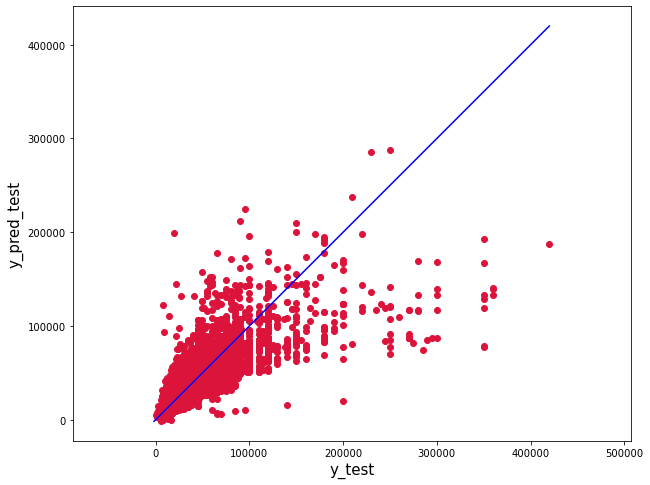

In [91]:
plt.figure(figsize=(10,8))
plt.scatter(y_test, y_pred_test, c='crimson')

p1 = max(max(y_pred_test), max(y_test))
p2 = min(min(y_pred_test), min(y_test))
plt.plot([p1,p2], [p1,p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_pred_test', fontsize=15)
plt.axis('equal')
plt.show()

 **Conclusion**
 --
 * From the graph above, can be seen that the y_pred_test (y value of the prediction) and y_test (y value prepare for test after prediction) .If the prediction is successful The red dot will follow the blue line. But this graph the red dot doesn't follow blue line. This prediction was unsuccessful, and with MAE is 5745, it was considered highly inaccurate.
 ---

SOURCE :    
1. https://www.livinginsider.com
2. https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
    